# Speech-to-Text
### Hecho por: Joshua Sancho, Steven Solís y Leonardo Bolaños

## Importar Librerías

In [58]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer
from datasets import load_dataset
import librosa

## Carga del Dataset

In [59]:
data_path = "datasets/stt/"
wavs_path = data_path + "train/"
metadata_path = data_path + "transcriptions.csv"

In [21]:
# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep=";")
metadata_df.columns = ["path", "sentence"]
metadata_df.head(100)

,path,sentence
0,1.wav,After they look at the s and p
1,2.wav,The s and p market is volatile today
2,3.wav,He invested in s and p index funds
3,4.wav,What's the current value of the s and p
4,5.wav,The s and p reached a new high
...,...,...
95,96.wav,Lifestyle choices can influence cancer risk
96,97.wav,Cancer screenings can detect abnormalities early
97,98.wav,Genetic factors play a role in some cancers
98,99.wav,Cancer awareness campaigns promote prevention ...


In [60]:
# Create a mask for validation indices: every 10th index starting from 9
val_indices = list(range(9, len(metadata_df), 10))

# Create the validation DataFrame by selecting the rows at the val_indices
df_val = metadata_df.iloc[val_indices]

# Create the training DataFrame by excluding the val_indices
df_train = metadata_df.drop(val_indices)

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the validation set: {len(df_val)}")

Size of the training set: 90
Size of the validation set: 10


In [62]:
import pandas as pd

# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep=";")
metadata_df.columns = ["path", "sentence"]

# Filter the DataFrame to include only sentences containing the word 'failure'
df_failure = metadata_df[metadata_df['sentence'].str.contains('failure', case=False)]

# Check the size of the filtered DataFrame
df_failure_size = len(df_failure)
if df_failure_size == 0:
    raise ValueError("No sentences containing the word 'failure' were found in the dataset.")

# Create a mask for validation indices: every 10th index starting from 9
val_indices = list(range(9, df_failure_size, 10))

# Create the validation DataFrame by selecting the rows at the val_indices
df_val = df_failure.iloc[val_indices]

# Create the training DataFrame by excluding the val_indices
df_train = df_failure.drop(df_failure.index[val_indices])

print(f"Size of the training set with 'failure': {len(df_train_failure)}")
print(f"Size of the validation set with 'failure': {len(df_val_failure)}")

Size of the training set with 'failure': 9
Size of the validation set with 'failure': 1


## Preprocesamiento

In [63]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz "]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' '] (size =28)


In [64]:
# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384

def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file)
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file, desired_channels=1)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

In [76]:
batch_size = 1
# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["path"]), list(df_train["sentence"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["path"]), list(df_val["sentence"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

## Visualización de los Datos

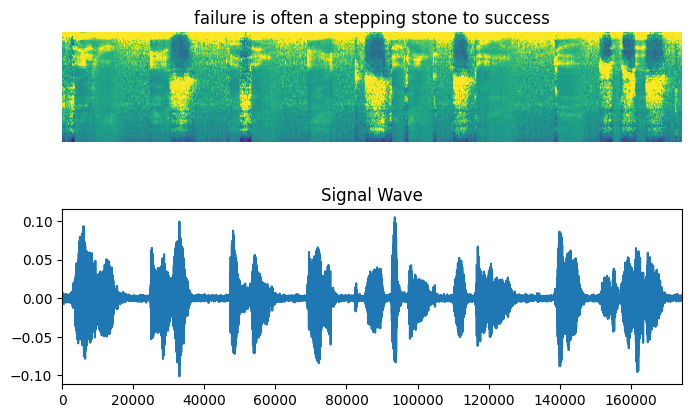

In [77]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["path"])[0])
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

## Modelo de Deep Learning CTC

In [78]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [79]:
def build_model(input_dim, output_dim, rnn_layers=10, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

# Entrenamiento del Modelo

In [ ]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in range(len(predictions)):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

In [83]:
model = keras.models.load_model('asr200.keras',custom_objects={'CTCLoss':CTCLoss})

In [81]:
# Define the number of epochs.
epochs = 50
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

Epoch 1/10
1/1 [==============================] - 2s 2s/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.4444
----------------------------------------------------------------------------------------------------
Target    : embracing failure as part of the journey is empowering
Prediction: enpresing failure as are of the hoarny is emavorein
----------------------------------------------------------------------------------------------------
9/9 [==============================] - 14s 1s/step - loss: 1.3657 - val_loss: 211.0746
Epoch 2/10
1/1 [==============================] - 0s 155ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.4444
----------------------------------------------------------------------------------------------------
Target    : embracing failure as part of the journey is empowering
Prediction: enpresing failure as ared

In [39]:
# Save the weights
# Save the entire model as a `.keras` zip archive.
model.save('asr200.keras')

In [84]:
def transcribe_audio(audio_file):
    # Read the audio file
    file = tf.io.read_file(audio_file)
    audio, _ = tf.audio.decode_wav(file, desired_channels=1)
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32)
    
    # Compute the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    
    # Normalization
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    
    # Add batch dimension
    spectrogram = tf.expand_dims(spectrogram, axis=0)
    
    # Pass through the model
    prediction = model.predict(spectrogram)
    
    # Decode the transcription
    transcription = decode_batch_predictions(prediction)
    
    return transcription

Audio file 1:
File name: datasets/stt/test\avocado.wav
Sampling rate: 22050
Number of samples: 31054
Duration (seconds): 1.4083446712018142


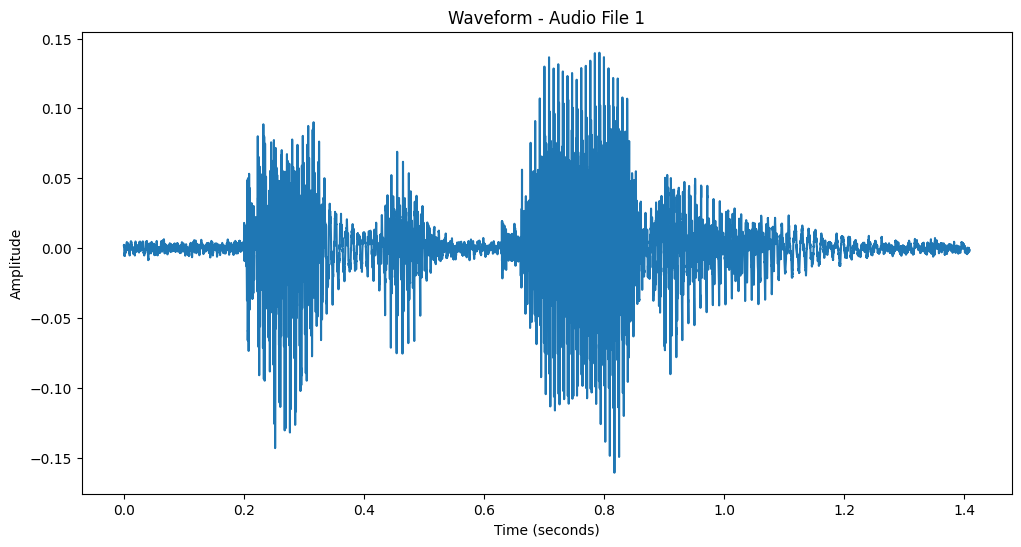

1/1 [==============================] - 0s 166ms/step
Transcription: ['avocado']
--------------------------------------------------------------------------------
Audio file 2:
File name: datasets/stt/test\bitcoin.wav
Sampling rate: 22050
Number of samples: 28814
Duration (seconds): 1.3067573696145125


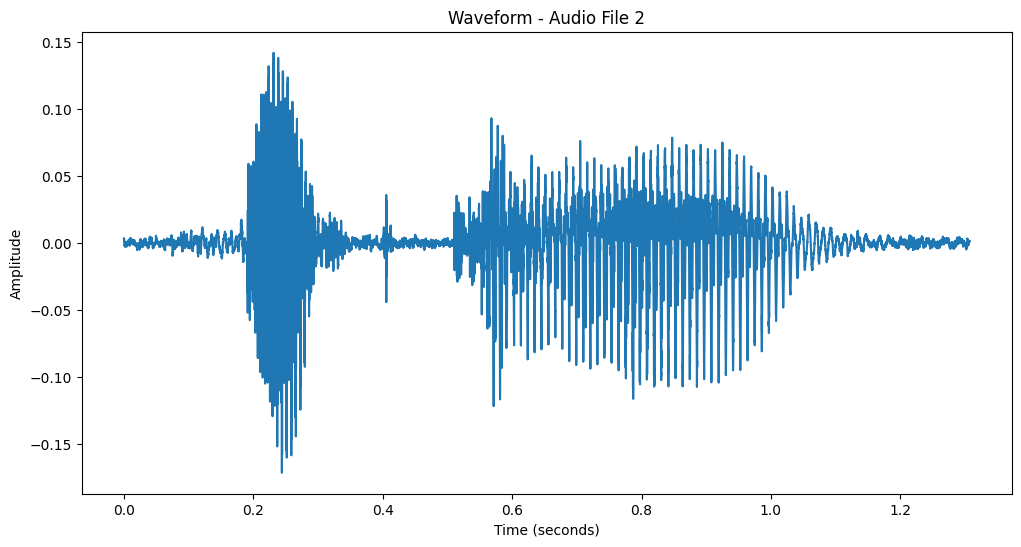

1/1 [==============================] - 0s 42ms/step
Transcription: ['bitcoin']
--------------------------------------------------------------------------------
Audio file 3:
File name: datasets/stt/test\cancer.wav
Sampling rate: 22050
Number of samples: 27534
Duration (seconds): 1.2487074829931972


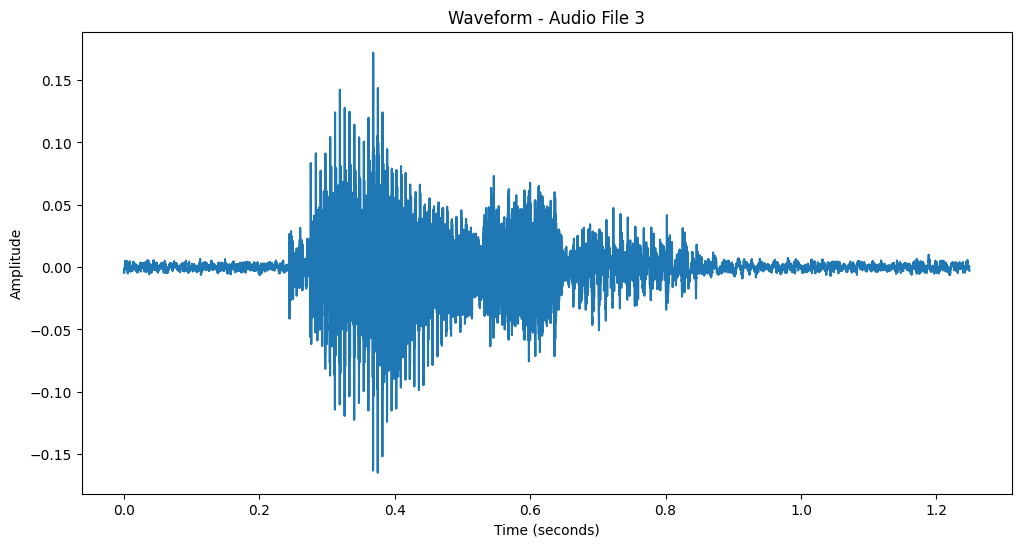

1/1 [==============================] - 0s 64ms/step
Transcription: ['cancer']
--------------------------------------------------------------------------------
Audio file 4:
File name: datasets/stt/test\drug.wav
Sampling rate: 22050
Number of samples: 20814
Duration (seconds): 0.9439455782312925


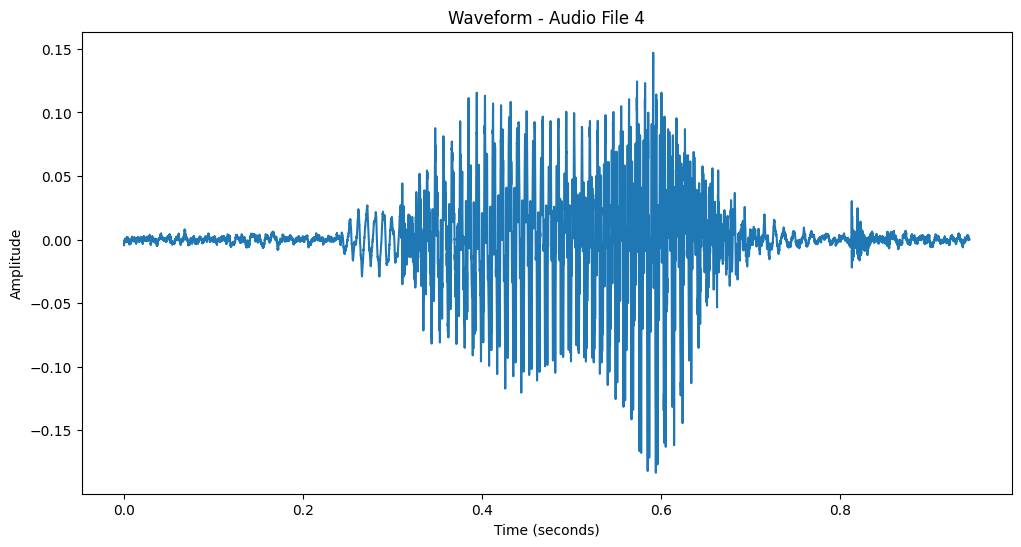

1/1 [==============================] - 0s 43ms/step
Transcription: ['drug']
--------------------------------------------------------------------------------
Audio file 5:
File name: datasets/stt/test\ethereum.wav
Sampling rate: 22050
Number of samples: 23054
Duration (seconds): 1.045532879818594


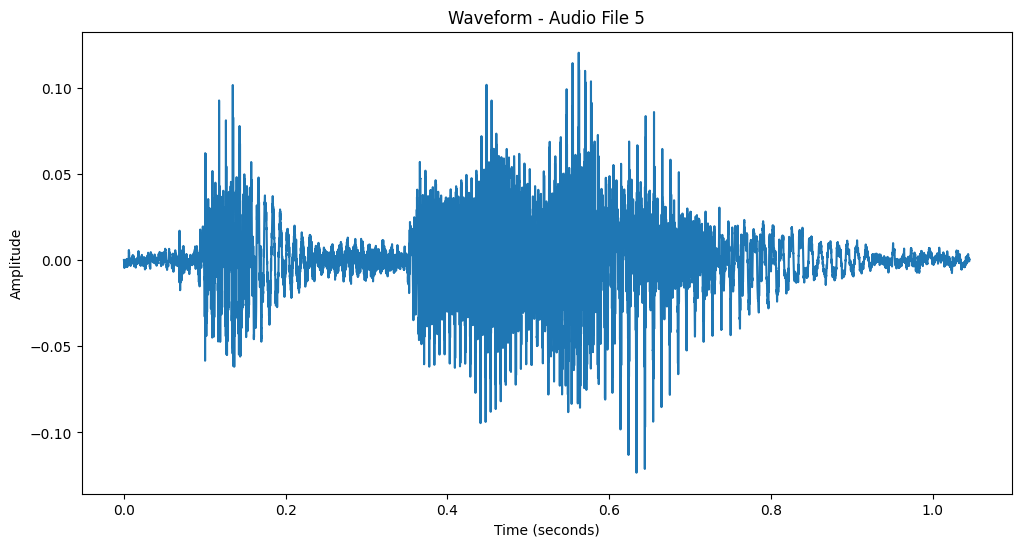

1/1 [==============================] - 0s 39ms/step
Transcription: ['ethereum']
--------------------------------------------------------------------------------
Audio file 6:
File name: datasets/stt/test\failure.wav
Sampling rate: 22050
Number of samples: 27534
Duration (seconds): 1.2487074829931972


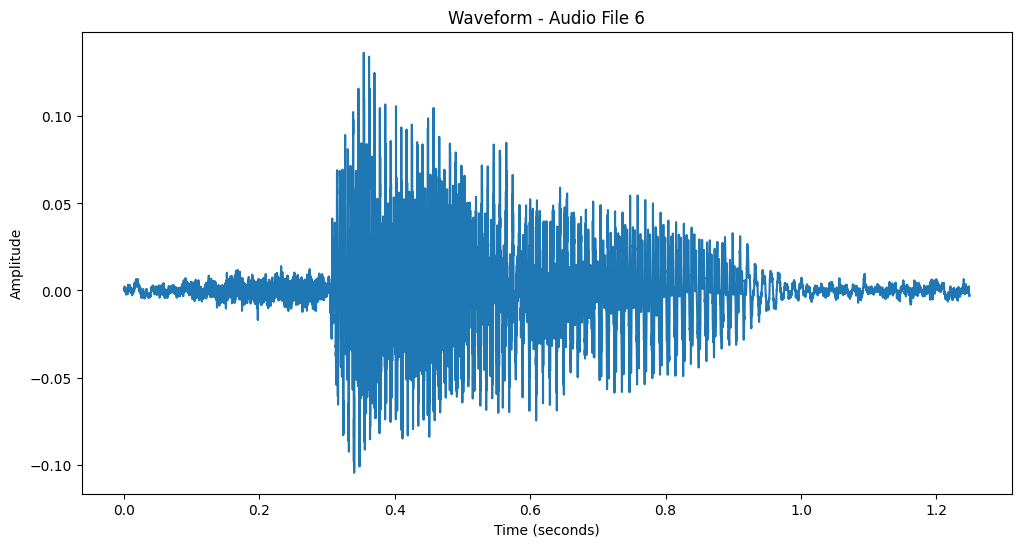

1/1 [==============================] - 0s 42ms/step
Transcription: ['feaer']
--------------------------------------------------------------------------------
Audio file 7:
File name: datasets/stt/test\pokemon.wav
Sampling rate: 22050
Number of samples: 26254
Duration (seconds): 1.1906575963718822


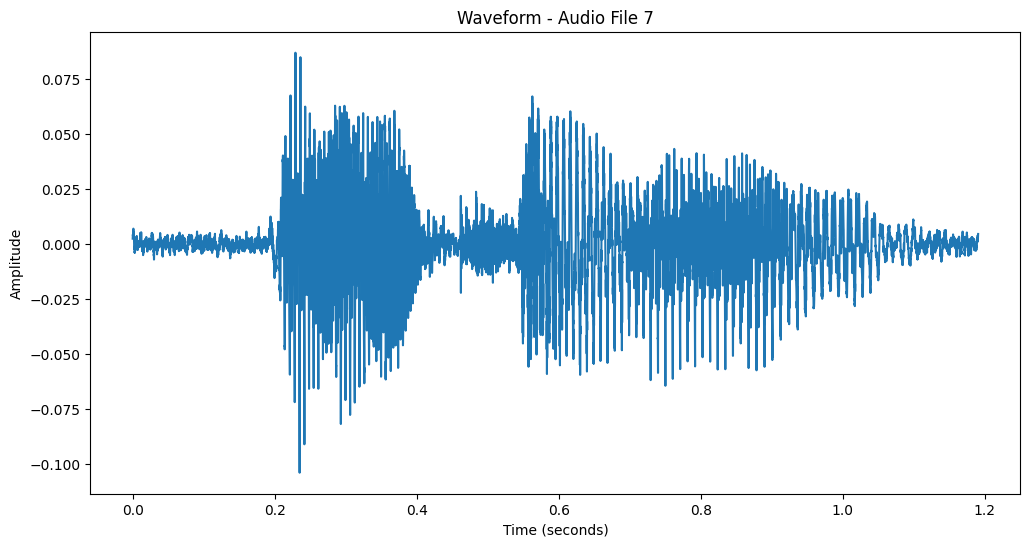

1/1 [==============================] - 0s 44ms/step
Transcription: ['pokemon']
--------------------------------------------------------------------------------
Audio file 8:
File name: datasets/stt/test\sandp.wav
Sampling rate: 22050
Number of samples: 40974
Duration (seconds): 1.8582312925170068


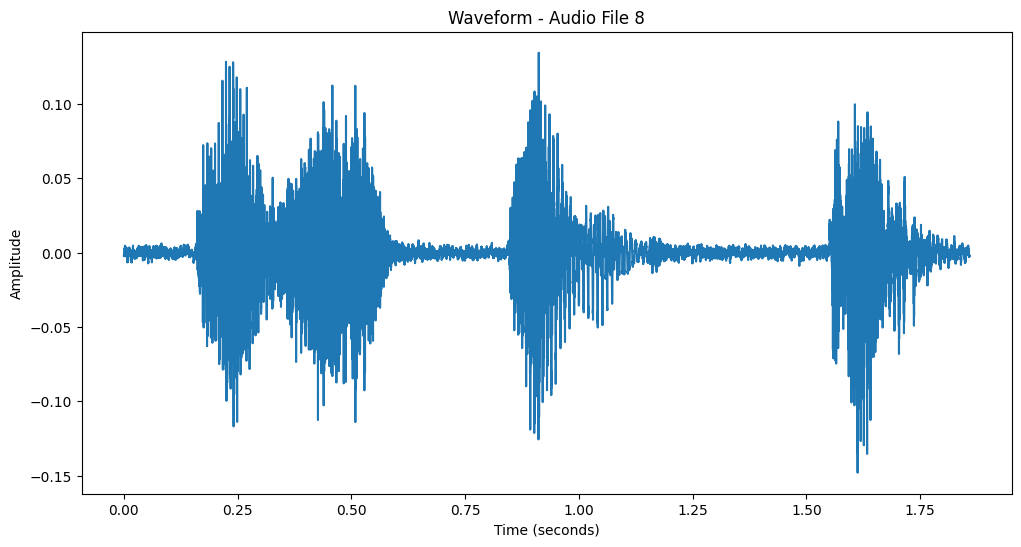

1/1 [==============================] - 0s 56ms/step
Transcription: ['s and p']
--------------------------------------------------------------------------------
Audio file 9:
File name: datasets/stt/test\sin nombre.wav
Sampling rate: 22050
Number of samples: 33614
Duration (seconds): 1.5244444444444445


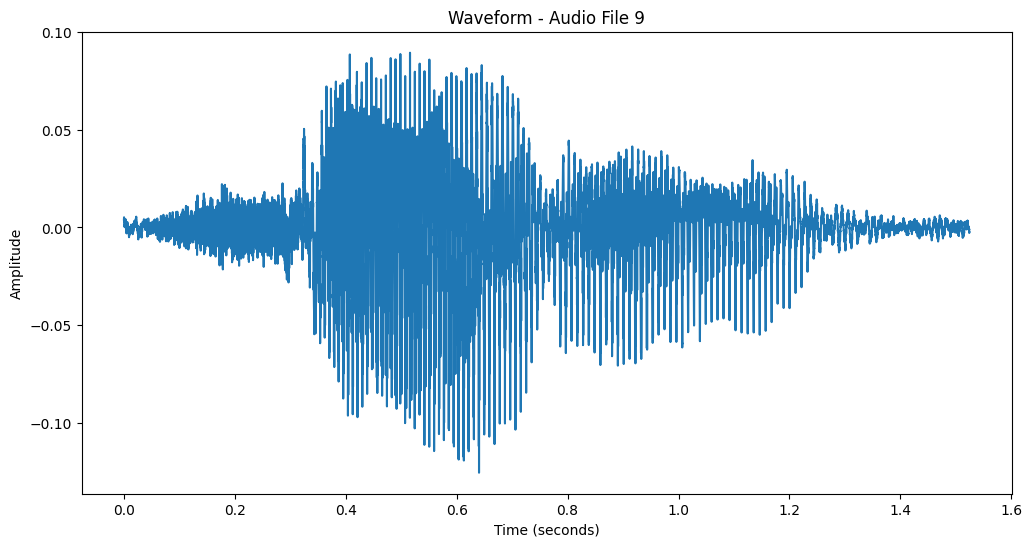

1/1 [==============================] - 0s 48ms/step
Transcription: ['fpeaiellyurre']
--------------------------------------------------------------------------------
Audio file 10:
File name: datasets/stt/test\stroke.wav
Sampling rate: 22050
Number of samples: 27854
Duration (seconds): 1.263219954648526


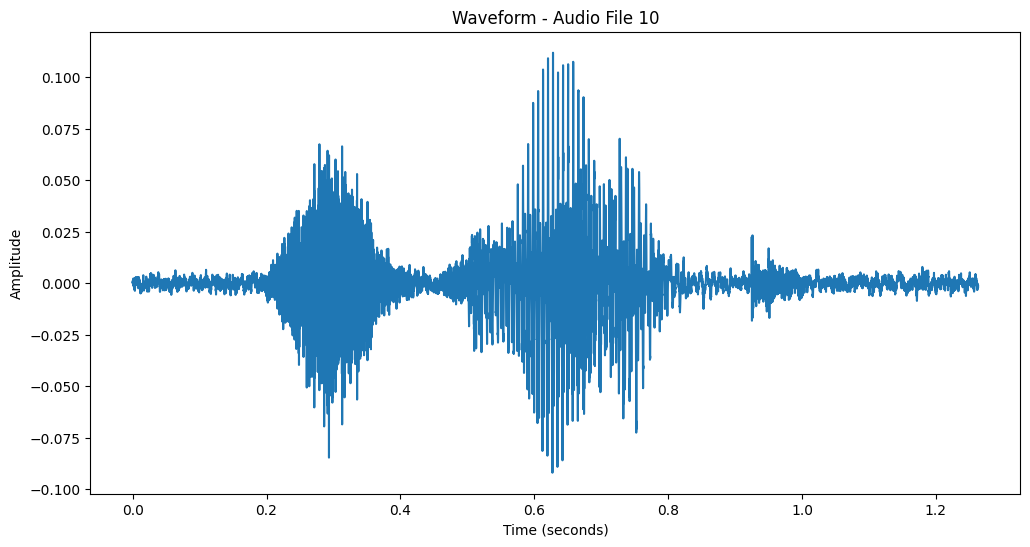

1/1 [==============================] - 0s 59ms/step
Transcription: ['stroke']
--------------------------------------------------------------------------------
Audio file 11:
File name: datasets/stt/test\wine.wav
Sampling rate: 22050
Number of samples: 22094
Duration (seconds): 1.0019954648526077


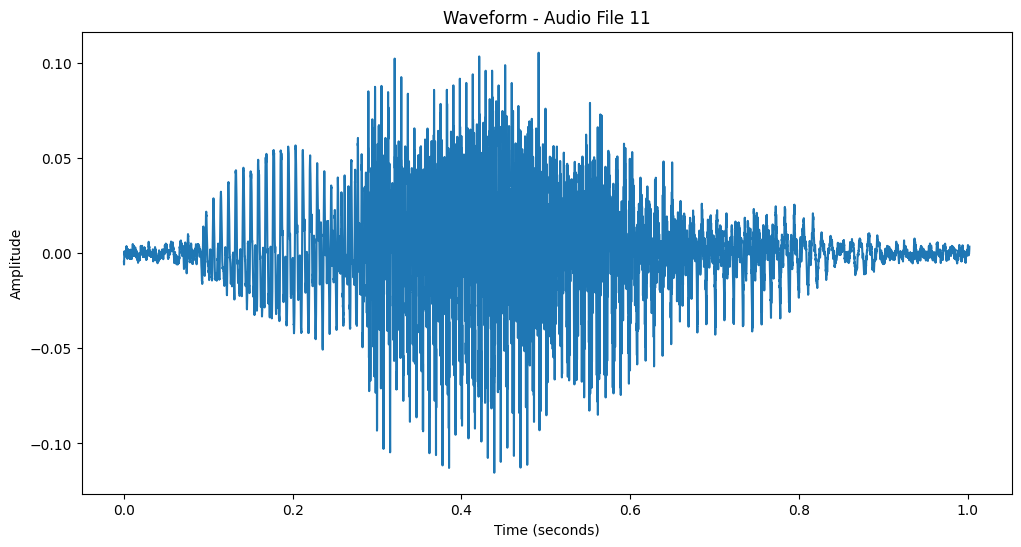

1/1 [==============================] - 0s 47ms/step
Transcription: ['wine']
--------------------------------------------------------------------------------


In [107]:
import os
import glob
import librosa
import matplotlib.pyplot as plt
import numpy as np

def process_wav_files(folder_path, transcribe_audio):
    # Get the list of .wav files in the folder
    wav_files = glob.glob(os.path.join(folder_path, '*.wav'))
    
    for i, audio_file in enumerate(wav_files):
        # Load and inspect the audio file
        y, sr = librosa.load(audio_file, sr=None)
        print(f"Audio file {i + 1}:")
        print("File name:", audio_file)
        print("Sampling rate:", sr)
        print("Number of samples:", len(y))
        print("Duration (seconds):", librosa.get_duration(y=y, sr=sr))

        # Plot waveform for the audio file
        plt.figure(figsize=(12, 6))
        plt.plot(np.linspace(0, len(y) / sr, num=len(y)), y)
        plt.title(f"Waveform - Audio File {i + 1}")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude")
        plt.show()

        # Call the transcribe_audio function with the audio file path
        transcription = transcribe_audio(audio_file)

        # Print the transcription
        print("Transcription:", transcription)
        print('-' * 80)

# Example usage
folder_path = 'datasets/stt/test'
process_wav_files(folder_path, transcribe_audio)
